In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_json('../data/Musical_Instruments_5.json', lines = True)

In [3]:
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
df.reviewTime=pd.to_datetime(df.reviewTime)
df.drop(columns=['unixReviewTime'], inplace=True)
df.rename(columns={'asin':'product_id'}, inplace=True)

### Clean up 'helpfulness' of reviews

In [5]:
df.helpful.value_counts()

[0, 0]      6796
[1, 1]      1159
[2, 2]       377
[0, 1]       334
[1, 2]       231
            ... 
[38, 40]       1
[88, 89]       1
[9, 18]        1
[25, 26]       1
[42, 43]       1
Name: helpful, Length: 269, dtype: int64

In [6]:
df['helpful_perc']=df.helpful.apply(lambda x: 0 if x[0]==0 or x[1]==0 else x[0]/x[1])
df['helpful_count']=df.helpful.apply(lambda x: x[0])

#### When were the reviewes written?

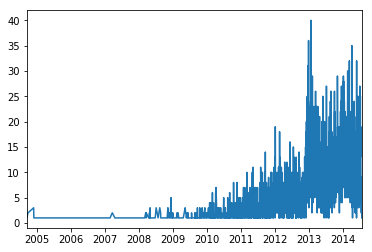

In [7]:
df.reviewTime.dt.date.value_counts().plot()

#### How many words in the review text?  Do longer reviews get more helpful counts? helpful perc?

In [9]:
df['review_wc']=df.reviewText.apply(lambda text: len(text.split()))

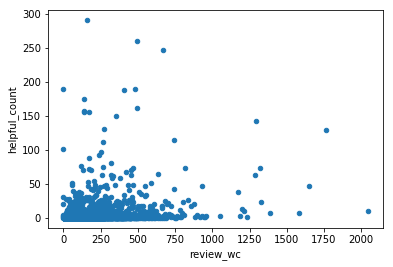

In [10]:
df.plot.scatter(x='review_wc', y='helpful_count')

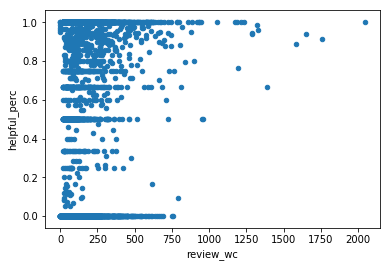

In [11]:
df.plot.scatter(x='review_wc', y='helpful_perc')

### ReviewText Clean up

In [12]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from wordcloud import WordCloud

In [13]:
stop = stopwords.words('english')
stemmer=PorterStemmer()
lemztr = WordNetLemmatizer()
def process_words(review):
    clean=[]
    review=re.sub("[^a-zA-Z]", " ", review) # letters only
    review=review.lower() # lower
    words=review.split()
    for word in words:
        if word in stop: # check for stop word
            continue
        else:
            word = stemmer.stem(word) # stemming
            word = lemztr.lemmatize(word) # lemmatize
        clean.append(word)
    return ' '.join(clean)

In [14]:
X=df.copy()
X['reviewText']=X.reviewText.apply(lambda x: process_words(x))

In [15]:
X[['reviewText']].head(10)

,reviewText
0,much write exactli suppos filter pop sound rec...
1,product exactli quit afford realiz doubl scree...
2,primari job devic block breath would otherwis ...
3,nice windscreen protect mxl mic prevent pop th...
4,pop filter great look perform like studio filt...
5,good bought anoth one love heavi cord gold con...
6,use monster cabl year good reason lifetim warr...
7,use cabl run output pedal chain input fender a...
8,perfect epiphon sheraton ii monster cabl well ...
9,monster make best cabl lifetim warranti doesnt...


## Visualizing Reviews -- Word Cloud

In [16]:
from PIL import Image
# guitar mask
g_mask = np.array(Image.open("../img/guitar.png"))

# Transform the mask 
transformed_g_mask = np.ndarray((g_mask.shape[0],g_mask.shape[1]), np.int32)

for i in range(len(transformed_g_mask)):
    transformed_g_mask[i] = list(map(lambda x: 255 if x ==0 else x, transformed_g_mask[i]))

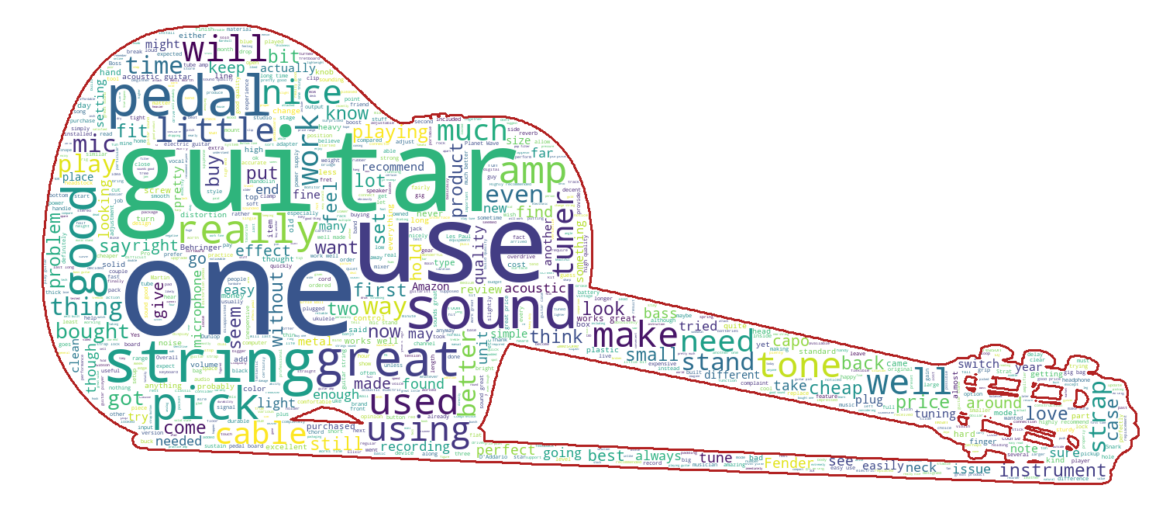

In [17]:
# combine all reviews
text=' '.join(df['reviewText'].tolist())

wc = WordCloud(background_color="white", max_words=1000, mask=transformed_g_mask,
               contour_width=2, contour_color='firebrick')

wc.generate(text) # Generate a wordcloud
wc.to_file("../img/wc_guitar_mask.png") # store to file

plt.figure(figsize=[20,10]) # show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


## Define Target (Positive, Neutral, Negative) based on Overall Rating

In [18]:
X['overall'].value_counts()

5    6938
4    2084
3     772
2     250
1     217
Name: overall, dtype: int64

- positive for 4 and 5 star overall rating
- neutral for 3 star rating
- negative for 1 and 2 star overall rating

In [19]:
X['target']=X['overall'].apply(lambda x: 'Positive' if x>=4 else 'Neutral' if x==3 else 'Negative')

In [20]:
X['target'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: target, dtype: int64

- Target is not distributed uniformly. 
- we will preserve this distribution in our model. so the data we feed to the model is as close to the reality as possible.

In [22]:
total=X.shape[0]
spl=X.groupby('target').agg({'review_wc':'count'}).reset_index().review_wc.apply(lambda x: int(x/total*9000))

In [23]:
negative=X[X['target']=='Negative'].sample(spl[0])
neutral=X[X['target']=='Neutral'].sample(spl[1])
positive=X[X['target']=='Positive'].sample(spl[2], replace=True)
train=pd.concat([positive,neutral,negative])

In [24]:
test_index=[]
for i in range(X.shape[0]):
    if i in train.index.tolist():
        continue
    test_index.append(i) 

- Test: we sample 500 observations from the original dataset that has not been selected for the training set.

In [25]:
spl=X.groupby('target').agg({'review_wc':'count'}).reset_index().review_wc.apply(lambda x: int(x/total*1000))

In [26]:
negative_test=X.iloc[test_index][X['target']=='Negative'].sample(spl[0])
neutral_test=X.iloc[test_index][X['target']=='Neutral'].sample(spl[1])
positive_test=X.iloc[test_index][X['target']=='Positive'].sample(spl[2])
test=pd.concat([negative_test,neutral_test,positive_test])

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
temp1=train['target'].value_counts()
temp2=test['target'].value_counts()
print(f'Test Dataset Total: {sum(temp2)}. Negative:{temp2.values[0]} , Neutral: {temp2.values[1]}, Positive: {temp2.values[2]}')
print(f'Training Dataset Total: {sum(temp1)}. Negative:{temp1.values[0]} , Neutral: {temp1.values[1]}, Positive: {temp1.values[2]}')

Test Dataset Total: 999. Negative:879 , Neutral: 75, Positive: 45
Training Dataset Total: 8999. Negative:7913 , Neutral: 677, Positive: 409


## Baseline Model: TextBlob built in sentiment analysis

In [28]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
def sentiment_func(X):
    sentiment = TextBlob(X['reviewText'])
    X['polarity'] = sentiment.polarity
    X['subjectivity'] = sentiment.subjectivity
    return X

In [30]:
train = train.apply(sentiment_func, axis=1)

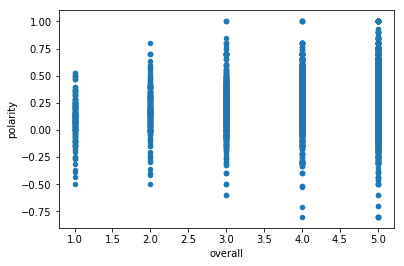

In [31]:
train.plot.scatter(x='overall',y='polarity')

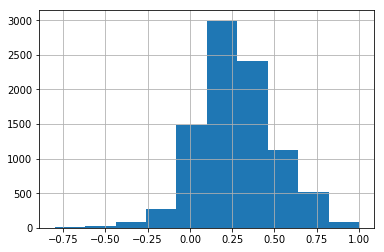

In [32]:
train['polarity'].hist()

In [33]:
params={1:[-0.1,0.1],2:[-0.15,-.15],3:[-0.2,0.2]}
train_pred={}
for i in params:
    param=params[i]
    train_pred[i]=train.polarity.apply(lambda x: 'Negative' if x<param[0] else 'Positive' if x>param[1] else 'Neutral')          
    

### Predict on Test Data
- As shown below, Threshold 2 gives us best accuracy but more review are predicted to be positive when they are neutral and negative. This is common when we have imbalanced label.
- Our objective is to maximize negative precision and positive precision.

In [34]:
test = test.apply(sentiment_func, axis=1)
test_pred={}
for i in params:
    param=params[i]
    test_pred[i]=test.polarity.apply(lambda x: 'Negative' if x<param[0] else 'Positive' if x>param[1] else 'Neutral')          

In [35]:
for i in range(1,4):
    print(f"****** Threashold {i} *******")
    conf_mat=np.array(confusion_matrix(test['target'], test_pred[i]))
    confusion = pd.DataFrame(conf_mat, index=['negative', 'neutral', 'positive'],\
                             columns=['predicted_negative','predicted_neutral','predicted_positive'])
    print("Accuracy Score: {0:.2f}%".format(accuracy_score(test['target'], test_pred[i])*100))
    print("-"*70)
    print("Confusion Matrix\n")
    print(confusion)
    print("-"*70)
    print("Classification Report\n")
    print(classification_report(test['target'], test_pred[i]))

****** Threashold 1 *******
Accuracy Score: 71.57%
----------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_neutral  predicted_positive
negative                   2                 17                  26
neutral                    4                 17                  54
positive                  28                155                 696
----------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    Negative       0.06      0.04      0.05        45
     Neutral       0.09      0.23      0.13        75
    Positive       0.90      0.79      0.84       879

    accuracy                           0.72       999
   macro avg       0.35      0.35      0.34       999
weighted avg       0.80      0.72      0.75       999

****** Threashold 2 *******
Accuracy Score: 85.79%
--------------------------------------------------------------

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## N-grams

## Word2Vec + CNN 